In [22]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from datetime import datetime
from utils.mvo_strategy import MVOStrategy, NaiveStrategy
import utils.eval_n_plot as eval_n_plot

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### dataload

In [ ]:
# import data from csv
freq = "1d"
data_dir = "../data/msci"

df_ret = pd.read_parquet(f"{data_dir}/returns_{freq}.parquet")
df_prices = pd.read_parquet(f"{data_dir}/prices_{freq}.parquet")

if "msci" in data_dir:
    df_ref = pd.read_parquet(f"{data_dir}/prices_msci_{freq}.parquet")
    ref_ticker = "MSCI World"
    data_src = "msci"
if "snp" in data_dir:
    df_ref = pd.read_parquet(f"{data_dir}/prices_sp500_{freq}.parquet")
    ref_ticker = "^GSPC"
    data_src = "snp"

sector_tickers = df_ret.columns.tolist()
print(sector_tickers)

['Canada', 'France', 'Germany', 'Italy', 'Japan', 'Switzerland', 'UK', 'US']


### params & modelrun

In [24]:
if freq == "1d":
    lookback_periods = [
        10,
        30,
        60,
        90,
        120,
        150,
        252,
        252 * 2,
        252 * 3,
        252 * 4,
        252 * 5,
        252 * 6,
    ]  # days
elif freq == "1mo":
    lookback_periods = [12, 24, 36, 60, 72, 120, 144]  # months

# full date range from paper
START_DATE = "2012-01-01"
END_DATE = "2021-12-31"

# yr = 2011
# START_DATE = f"{yr}-01-01"
# END_DATE = f"{yr}-12-31"

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
# also add start and end date to the name
results_dir = (
    f"../results/{timestamp}_mvo_backtest_{data_src}=[{START_DATE},{END_DATE}]_freq={freq}"
)
os.makedirs(results_dir, exist_ok=True)

# SAVE all relevant params and paths in config file
config = {
    'freq': freq,
    'data_dir': data_dir,
    'lookback_periods': lookback_periods,
    'START_DATE': START_DATE,
    'END_DATE': END_DATE,
    'results_dir': results_dir,
    'sector_tickers': sector_tickers,
}

with open(os.path.join(results_dir, 'config.json'), 'w') as f:
    json.dump(config, f, indent=4)

In [25]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# MVO strategy

all_mvo_history = []
all_mvo_metrics = []
all_mvo_portfolios = []

for lookback in lookback_periods:
    print(f"Running MVO with lookback period: {lookback}")
    optimizer = MVOStrategy(tickers=sector_tickers, lookback=lookback)
    portfolio = optimizer.backtest(
        df_ret, df_prices, start_date=START_DATE, end_date=END_DATE, method="scipy"
    )

    portfolio_df = pd.DataFrame(portfolio.get_history())
    portfolio_df["lookback"] = lookback

    portfolio_metrics = portfolio.calc_metrics()
    portfolio_metrics["lookback"] = lookback

    all_mvo_history.append(portfolio_df)
    all_mvo_metrics.append(portfolio_metrics)
    all_mvo_portfolios.append(portfolio)

# Combine all results
mvo_history_df = pd.concat(all_mvo_history, axis=0)
mvo_metrics_df = pd.DataFrame(all_mvo_metrics)

mvo_history_df.to_parquet(f"{results_dir}/mvo_history.parquet")
mvo_metrics_df.to_csv(f"{results_dir}/mvo_metrics.csv")

Running MVO with lookback period: 10


Running backtest: 100%|██████████| 2610/2610 [00:11<00:00, 236.06it/s]


Running MVO with lookback period: 30


Running backtest: 100%|██████████| 2610/2610 [00:12<00:00, 203.06it/s]


Running MVO with lookback period: 60


Running backtest: 100%|██████████| 2610/2610 [00:14<00:00, 182.53it/s]


Running MVO with lookback period: 90


Running backtest: 100%|██████████| 2610/2610 [00:14<00:00, 178.05it/s]


Running MVO with lookback period: 120


Running backtest: 100%|██████████| 2610/2610 [00:15<00:00, 164.79it/s]


Running MVO with lookback period: 150


Running backtest: 100%|██████████| 2610/2610 [00:16<00:00, 157.89it/s]


Running MVO with lookback period: 252


Running backtest: 100%|██████████| 2610/2610 [00:17<00:00, 148.83it/s]


Running MVO with lookback period: 504


Running backtest: 100%|██████████| 2610/2610 [00:18<00:00, 137.57it/s]


Running MVO with lookback period: 756


Running backtest: 100%|██████████| 2610/2610 [00:18<00:00, 138.14it/s]


Running MVO with lookback period: 1008


Running backtest: 100%|██████████| 2610/2610 [00:19<00:00, 134.96it/s]


Running MVO with lookback period: 1260


Running backtest: 100%|██████████| 2610/2610 [00:19<00:00, 135.38it/s]


Running MVO with lookback period: 1512


Running backtest: 100%|██████████| 2610/2610 [00:19<00:00, 133.93it/s]


In [26]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# Naive strategy ( no need for lookback )

optimizer = NaiveStrategy(tickers=sector_tickers)
portfolio = optimizer.backtest(
    df_ret, df_prices, start_date=START_DATE, end_date=END_DATE
)

naive_portfolio_df = pd.DataFrame(portfolio.get_history())
naive_portfolio_metrics = pd.DataFrame(portfolio.calc_metrics(), index=[0])

naive_portfolio_df.to_parquet(f"{results_dir}/naive_history.parquet")
naive_portfolio_metrics.to_csv(f"{results_dir}/naive_metrics.csv")

Running backtest: 100%|██████████| 2610/2610 [00:02<00:00, 995.04it/s] 


### plot

In [27]:
# results_dir = "../results/20250702_1539_mvo_backtest_[2012-01-01,2021-12-31]_freq=1d"

# mvo_history_df = pd.read_parquet(f"{results_dir}/mvo_history.parquet")
# mvo_metrics_df = pd.read_csv(f"{results_dir}/mvo_metrics.csv")

# naive_portfolio_df = pd.read_parquet(f"{results_dir}/naive_history.parquet")
# naive_metrics_df = pd.read_csv(f"{results_dir}/naive_metrics.csv")

In [28]:
initial_balance = 100_000
shares_spy = initial_balance / df_ref[ref_ticker].loc[df_ref.index > START_DATE].iat[0]

spy_lastdate = df_ref[ref_ticker].loc[df_ref.index < END_DATE].index.max()
spy_lastval = (df_ref.loc[spy_lastdate] * shares_spy).values[0]
print(f"{ref_ticker} final value: {spy_lastval:.2f}")

naive_lastval = naive_portfolio_df['portfolio_value'].loc[END_DATE]
print(f"Naive portfolio final value: {naive_lastval:.2f}")

# compare if MVO with lookback outperforms SnP500
# simple comparison with True False in new column
df = (
    mvo_history_df.groupby("lookback")[["portfolio_value"]]
    .last()
    .sort_values(by="portfolio_value", ascending=False)
)
df["outperforms_spy"] = df["portfolio_value"] > spy_lastval
df["outperforms_naive"] = df["portfolio_value"] > naive_lastval
df

MSCI World final value: 75446.24
Naive portfolio final value: 232586.92


,portfolio_value,outperforms_spy,outperforms_naive
lookback,,,
1008,403695.534885,True,True
1260,402832.167194,True,True
756,389263.801939,True,True
1512,381583.427908,True,True
504,330365.313030,True,True
60,313210.542541,True,True
90,277397.532268,True,True
252,259642.126736,True,True
120,250319.065674,True,True


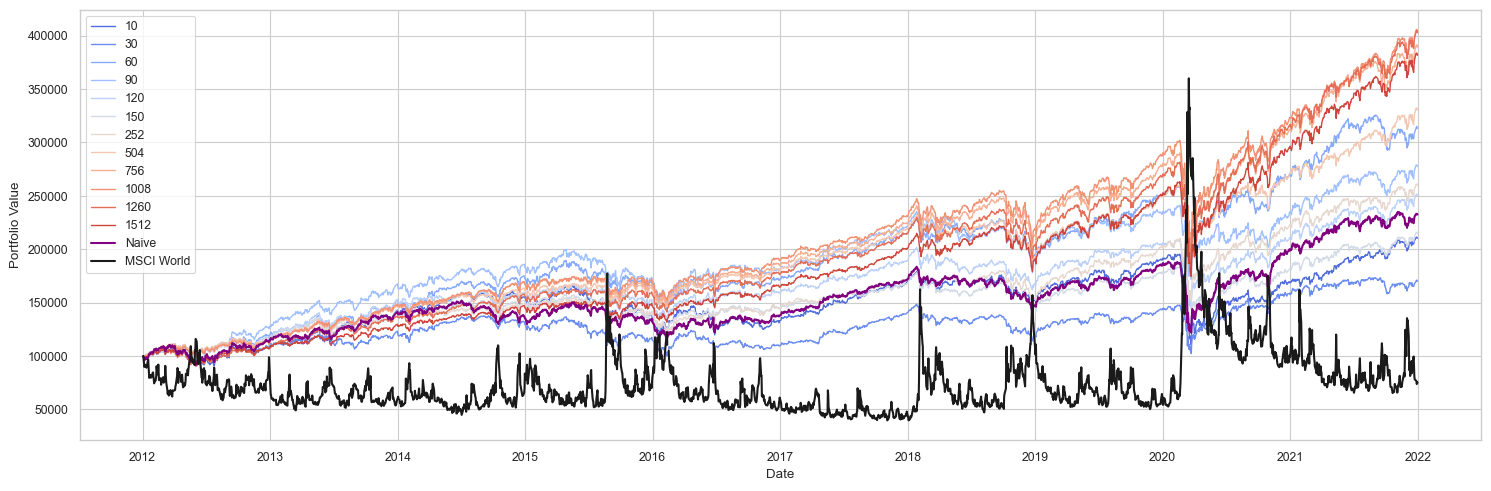

In [ ]:
eval_n_plot.plot_portfolio_val(
    START_DATE,
    END_DATE,
    mvo_history_df,
    naive_portfolio_df=naive_portfolio_df,
    df_ref=df_ref,
    ref_ticker=ref_ticker,
    initial_shares=shares_spy,
    results_dir=results_dir,
)

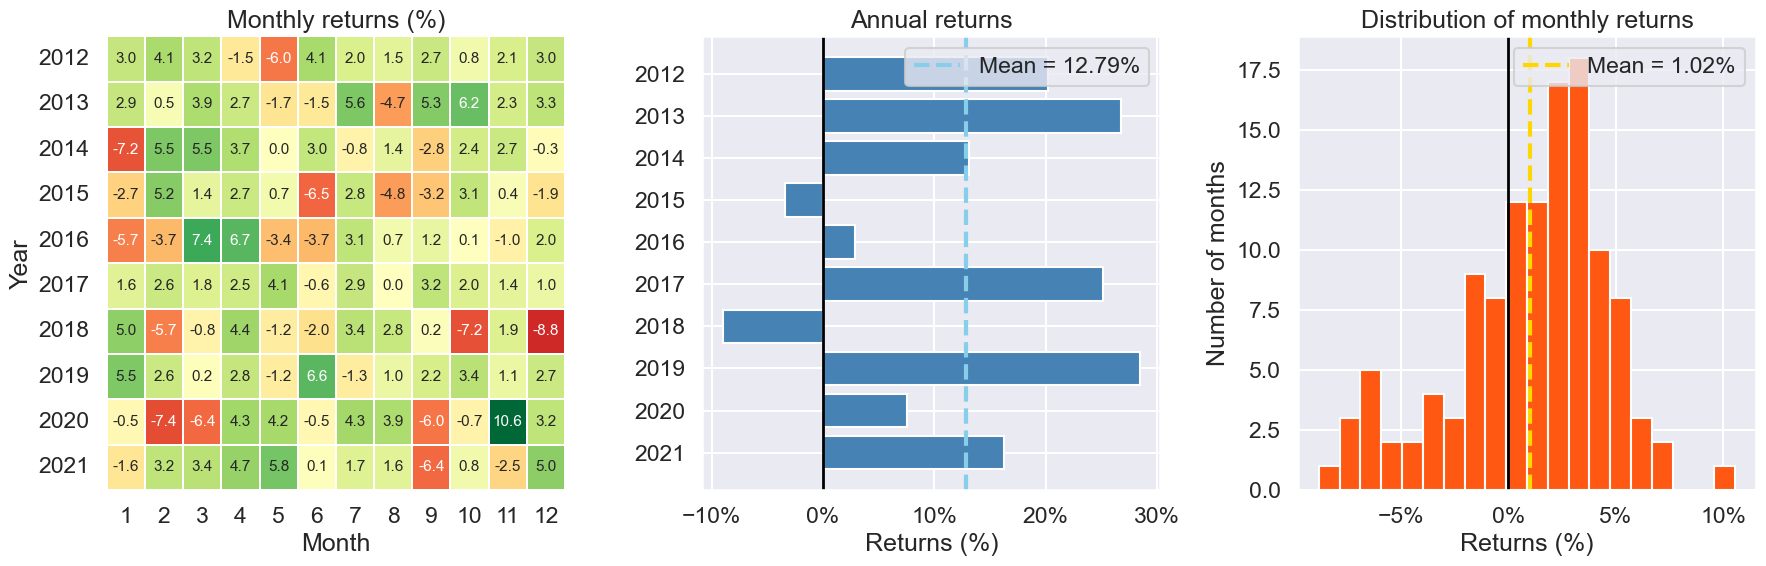

In [30]:
# Filter relevant lookback
lookback = 60
focus_df = mvo_history_df[mvo_history_df["lookback"] == lookback]

monthly_pivot, annual_df = eval_n_plot.calc_monthly_annual_rets(focus_df, initial_balance)
fname = f"paper_fig4_mvo_returns_{lookback}"

eval_n_plot.plot_fig4(monthly_pivot, annual_df, results_dir, fname)

### Metrics by Lookback

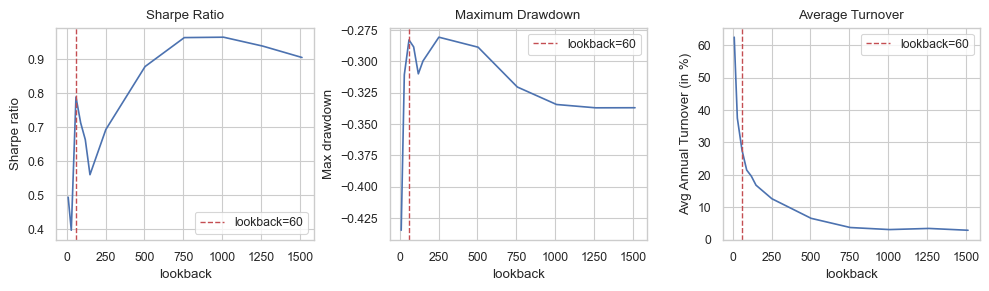

In [31]:
eval_n_plot.plot_fig2(mvo_metrics_df, results_dir, f"mvo_lookback_metrics_{data_src}")

# # Print detailed metrics
# print("\nDetailed Metrics by Lookback Period:")
# df = metrics_df.set_index("lookback")
# df.T

### Metrics by Year